简单的15min, MA3 upper MA60 or MA72

prepare data

qfq_data calculate the signal, non fq data to backtest

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import statsmodels.api as sm
# import tushare as ts
import QUANTAXIS as QA
import talib as ta
import datetime, time


In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')

In [4]:
code = '002366'
start = '2018-07-01'
end = '2018-12-31'

In [5]:
data = QA.QA_fetch_stock_min_adv(code, start, end, frequence='15min')

In [6]:
data_qfq = data.to_qfq()

In [20]:
data_qfq.data.head()

,,open,high,low,close,volume,amount,preclose,type
datetime,code,,,,,,,,
2018-07-02 09:45:00,002366,14.091813,14.328982,14.032520,14.180751,2.849407e+06,40428608.0,NaN,15min
2018-07-02 10:00:00,002366,14.190633,14.240043,14.131341,14.210397,8.865564e+05,12574384.0,14.180751,15min
2018-07-02 10:15:00,002366,14.210397,14.388274,14.180751,14.358628,1.729701e+06,24761916.0,14.210397,15min
2018-07-02 10:30:00,002366,14.368510,14.368510,14.249925,14.259807,8.759310e+05,12544080.0,14.358628,15min
2018-07-02 10:45:00,002366,14.249925,14.279572,14.160987,14.210397,6.505731e+05,9252736.0,14.259807,15min


calculate ATR

In [79]:
ind_atr = data_qfq.add_func(QA.QA_indicator_ATR).shift(1)

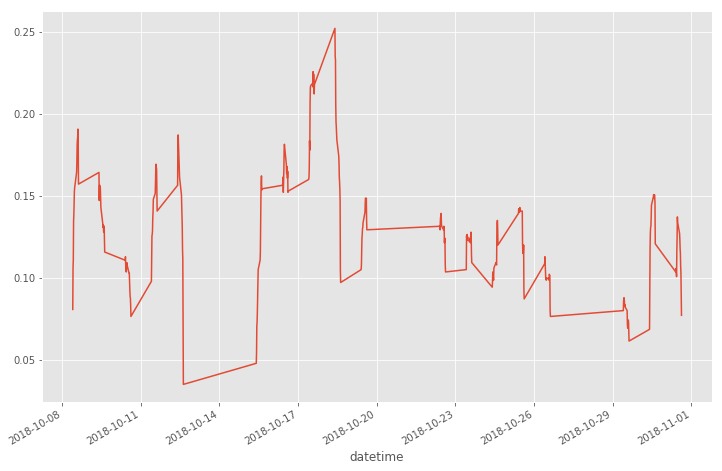

In [51]:
ind_atr.xs(code,level=1)['2018-10'].ATR.plot();

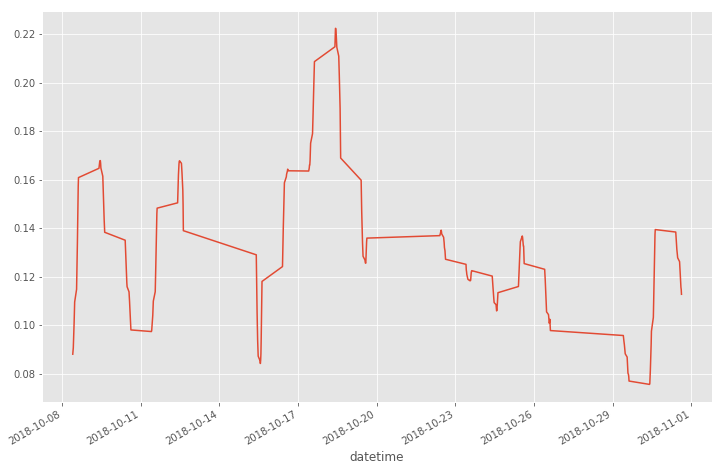

In [52]:
ind_atr.rolling(14).mean().xs(code,level=1)['2018-10'].ATR.plot();

以下的ATR定义为买入信号时的ATR

---
如果从买入价跌去2倍ATR时,便止损,假设此时最多亏损2%的金额,则:

2 * ATR * 买入的股数 = 2% * 总金额

==>

买入的手数 = 1% * 总金额 / ATR // 100

In [57]:
initial_asset = 5e4

In [59]:
initial_asset * 0.01

500.0

In [61]:
data.close.iloc[100]

13.32

In [66]:
200 * data.close.iloc[100]

2664.0

In [69]:
ind_atr.ATR.iloc[100] * 33 * 200 

987.64095665342109

In [84]:
ind_atr.head(20)

,,TR,ATR
datetime,code,,
2018-07-02 09:45:00,002366,NaN,NaN
2018-07-02 10:00:00,002366,0.108703,NaN
2018-07-02 10:15:00,002366,0.207523,NaN
2018-07-02 10:30:00,002366,0.118585,NaN
2018-07-02 10:45:00,002366,0.118585,NaN
2018-07-02 11:00:00,002366,0.098821,NaN
2018-07-02 11:15:00,002366,0.049410,NaN
2018-07-02 11:30:00,002366,0.079056,NaN
2018-07-02 13:15:00,002366,0.069174,NaN


In [98]:
not(np.isnan(ind_atr.loc['2018-07-02 10:00'].ATR.iloc[0]))

False

In [ ]:
np.isnan

In [86]:
ind_atr.loc['2018-07-02 15:00'].ATR.iloc[0]

0.13199603980430982

In [68]:
initial_asset * 0.01 / (ind_atr.ATR.iloc[100]) // 100

33.0

ma上穿下穿信号

In [60]:
def MA_system(dataframe):
    """
    Implement:
        根据ATR设定仓位
        RSI设置止损
        什么时候接回来
        当MA3上穿到MA60之上时,并且volume大于5日均量线,记为做多; 这个忘记做了...
        还没有做止损, high / low limit的情况也要考虑到
        试试用rsi做改进?
        
    Arguments:
        
    Returns:
    
    """
    CLOSE = dataframe.close
#     VOL = dataframe.volume
    MA3 = CLOSE.rolling(3).mean()
    MA60 = CLOSE.rolling(60).mean()
#     VOL_MA3 = VOL.rolling(3).mean()
#     VOL_MA60 = VOL.rolling(60).mean()
#     UCROSS = (QA.CROSS(MA3, MA60) & QA.CROSS(VOL_MA3, VOL_MA60)).shift(1)
    UCROSS = QA.CROSS(MA3, MA60).shift(1)
    DCROSS = QA.CROSS(MA60, MA3).shift(1)
    return pd.DataFrame({'UCROSS':UCROSS, 'DCROSS':DCROSS})

In [61]:
ind_ma = data_qfq.add_func(MA_system)

In [121]:
# ind_ma.xs(code, level=1)['2018-10-08 11:00':'2018-10-08']

In [18]:
# ind_ma.xs(code, level=1)['2018-10'].plot();

In [71]:
ind_ma.UCROSS.iloc[100]

0

回测

In [80]:
Broker = QA.QA_BacktestBroker()
User = QA.QA_User(username='quantaxis', password='quantaxis')
Portfolio = User.new_portfolio('qatestportfolio')

In [81]:
Account = Portfolio.new_account(account_cookie='user_mamin_002366',
                           init_cash=200000,
                           allow_t0 = True,
                           frequence=QA.FREQUENCE.FIFTEEN_MIN)

In [82]:
Account.commission_coeff = 0.00012

In [83]:
data_backtest = data

In [103]:
# Account.settle() 结算函数

In [ ]:
# 研究止损的问题

In [114]:
0.01 * Account.init_cash / cur_atr // 100

215.0

In [84]:
_date = None
for items in data_backtest.panel_gen: # 一根bar过去了
    
    # 进行结算
    if _date != items.date[0]:
        print('try to settle')
        _date = items.date[0]
        Account.settle()
    
    for item in items.security_gen:
        daily_ind=ind_ma.loc[item.index] # item.index是index, 然后取到这一天ma的指标值
        if daily_ind.UCROSS.iloc[0] > 0:
            # if Account.sell_available.get(item.code[0], 0) == 0: # 这个是用来判断是否为空仓
            cur_atr = ind_atr.loc[item.index].ATR.iloc[0] # 获取当前日的ATR
            if not(np.isnan(cur_atr)): # 如果ATR不为空
                order_num = 0.01 * Account.init_cash / cur_atr // 100 * 100 # 这里暂时用初始cash进行分配仓位
                order = Account.send_order(
                    code=item.code[0],
                    time=item.datetime[0],
                    amount=order_num,
                    towards=QA.ORDER_DIRECTION.BUY,
                    price=0,
                    order_model=QA.ORDER_MODEL.CLOSE,
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                )
                if order:
                    Broker.receive_order(QA.QA_Event(order=order, market_data=item))
                    trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                    res = trade_mes.loc[order.account_cookie, order.realorder_id]
                    print('side : buy, trade_id : %s, ' \
                          'trade_price : %s, trade_amount : %s ' \
                          'trade_time : %s' % 
                          (res.trade_id, res.trade_price,
                                res.trade_amount, res.trade_time))
                    order.trade(res.trade_id, res.trade_price,
                                res.trade_amount, res.trade_time)
                    # 若考虑止损, 还需要判断是否交易成功, 需要记录下成交价格
                    # 但止损的价格判断, 还需要考虑到复权的问题, 因为ATR是复权后计算出来的
                    # 所以需要记录下成交时候的时间点，然后对应时间点上复权后的成交价是多少
                    # 再算出止损价位, 逆向复权成为不复权的止损价
                    # 或者直接使用持仓的市值来判断是否需要止损?
        elif daily_ind.DCROSS.iloc[0] > 0:
            if Account.sell_available.get(item.code[0], 0) > 0:
                _hold = Account.sell_available.get(item.code[0], 0)
                order1 = Account.send_order(
                    code=item.code[0],
                    time=item.datetime[0],
                    amount=_hold,
                    towards=QA.ORDER_DIRECTION.SELL,
                    price=0,
                    order_model=QA.ORDER_MODEL.CLOSE,
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                )
                if order1:
                    Broker.receive_order(QA.QA_Event(
                        order=order1, market_data=item))
                    trade_mes = Broker.query_orders(
                        Account.account_cookie, 'filled')
                    res = trade_mes.loc[order1.account_cookie, order1.realorder_id]
                    print('side : sell, trade_id : %s, ' \
                          'trade_price : %s, trade_amount : %s ' \
                          'trade_time : %s' % 
                          (res.trade_id, res.trade_price,
                                res.trade_amount, res.trade_time))
                    order1.trade(res.trade_id, res.trade_price,
                                res.trade_amount, res.trade_time)

try to settle
try to settle
try to settle
try to settle
try to settle
try to settle
try to settle
try to settle
try to settle
side : buy, trade_id : Trade_YlaPi9se, trade_price : 13.58, trade_amount : 11800 trade_time : 2018-07-12 13:15:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
try to settle
try to settle
try to settle
try to settle
try to settle
side : sell, trade_id : Trade_a0ZhRlFq, trade_price : 14.16, trade_amount : 11800 trade_time : 2018-07-19 13:30:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
try to settle
side : buy, trade_id : Trade_cdrvWOsB, trade_price : 14.35, trade_amount : 19900 trade_time : 2018-07-20 14:45:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
try to settle
try to settle
side : buy, trade_id : Trade_6ZepLIaJ, trade_price : 14.78, trade_amount : 10400 trade_time : 2018-07-24 10:30:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
try to settle
try to settle
try to settle
side : sell, trade_id : Trade_Dw4AOejK, trade_price : 1

In [70]:
Account.hold_price()

<bound method QA_Account.hold_price of < QA_Account user_mamin_002366 market: stock_cn>>

In [78]:
Account.history_table

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax,message,frozen
0,2018-07-12 13:15:00,002366,13.58,12000,37020.44480,Order_v9RwPeGV,Order_v9RwPeGV,Trade_WGSC8qFz,user_mamin_002366,19.55520,0.000,None,0
1,2018-07-19 13:30:00,002366,14.16,-12000,206750.13440,Order_y5GZcY9W,Order_y5GZcY9W,Trade_0UibtV9F,user_mamin_002366,20.39040,169.920,None,0
2,2018-07-24 10:30:00,002366,14.78,10400,53019.68896,Order_ZtWDxMbp,Order_ZtWDxMbp,Trade_zry9UdGq,user_mamin_002366,18.44544,0.000,None,0
3,2018-07-27 13:45:00,002366,14.71,-10400,205832.34688,Order_YDazMeWc,Order_YDazMeWc,Trade_YmUNM4Xj,user_mamin_002366,18.35808,152.984,None,0
4,2018-08-08 11:00:00,002366,12.87,14000,25630.72528,Order_8zR1kghW,Order_8zR1kghW,Trade_svkQPOI8,user_mamin_002366,21.62160,0.000,None,0
5,2018-08-09 10:00:00,002366,12.51,-14000,200574.56848,Order_9QWCLeYp,Order_9QWCLeYp,Trade_d5qmXy0W,user_mamin_002366,21.01680,175.140,None,0
6,2018-08-09 10:45:00,002366,12.76,12400,42331.58160,Order_M92zPXau,Order_M92zPXau,Trade_g8KyBc74,user_mamin_002366,18.98688,0.000,None,0
7,2018-08-13 10:15:00,002366,12.55,-12400,197777.28720,Order_uSZGpRBn,Order_uSZGpRBn,Trade_EoVridB4,user_mamin_002366,18.67440,155.620,None,0
8,2018-08-23 14:30:00,002366,12.15,16100,2138.81340,Order_KqeTuWc3,Order_KqeTuWc3,Trade_NSIAjHvs,user_mamin_002366,23.47380,0.000,None,0
9,2018-08-30 10:00:00,002366,11.45,-16100,186277.34700,Order_GXPkr4dn,Order_GXPkr4dn,Trade_gXqt4138,user_mamin_002366,22.12140,184.345,None,0


In [76]:
r = QA.QA_Risk(Account)

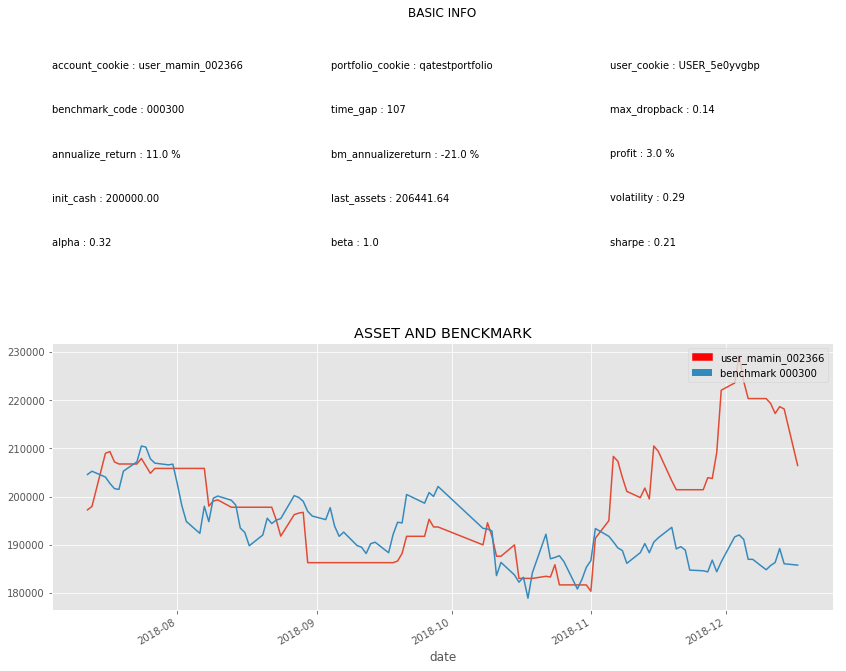

In [77]:
r.plot_assets_curve().show()

试过t0和非t0, 发现不开t0效果更好,这就很尴尬了...

试一下2018全年的,还有从10月下旬到19年的

可以仿造example中的simplebacktest.py, 改造成函数, 方便回测

今天就这样吧

RSI

In [87]:
ind_rsi = data_qfq.add_func(QA.QA_indicator_RSI).shift(1)

In [88]:
ind_rsi.head()

,,RSI1,RSI2,RSI3
datetime,code,,,
2018-07-02 09:45:00,002366,NaN,NaN,NaN
2018-07-02 10:00:00,002366,100.000000,100.000000,100.00000
2018-07-02 10:15:00,002366,100.000000,100.000000,100.00000
2018-07-02 10:30:00,002366,100.000000,100.000000,100.00000
2018-07-02 10:45:00,002366,81.481481,89.641434,77.61194


In [94]:
Broker = QA.QA_BacktestBroker()
User = QA.QA_User(username='quantaxis', password='quantaxis')
Portfolio = User.new_portfolio('qatestportfolio')

Account_rsi = Portfolio.new_account(account_cookie='user_rsimin_002366',
                           init_cash=200000,
                           allow_t0 = True,
                           frequence=QA.FREQUENCE.FIFTEEN_MIN)

Account_rsi.commission_coeff = 0.00012
data_backtest = data

In [95]:
_date = None
for items in data_backtest.panel_gen: # 一根bar过去了
    
    # 进行结算
    if _date != items.date[0]:
        print('try to settle')
        _date = items.date[0]
        Account_rsi.settle()
    
    for item in items.security_gen:
        daily_ind=ind_rsi.loc[item.index] # item.index是index, 然后取到这一天ma的指标值
        if daily_ind.RSI1.iloc[0] < 30:
            # if Account_rsi.sell_available.get(item.code[0], 0) == 0: # 这个是用来判断是否为空仓
            cur_atr = ind_atr.loc[item.index].ATR.iloc[0] # 获取当前日的ATR
            if not(np.isnan(cur_atr)): # 如果ATR不为空
                order_num = 0.01 * Account_rsi.init_cash / cur_atr // 100 * 100 # 这里暂时用初始cash进行分配仓位
                order = Account_rsi.send_order(
                    code=item.code[0],
                    time=item.datetime[0],
                    amount=order_num,
                    towards=QA.ORDER_DIRECTION.BUY,
                    price=0,
                    order_model=QA.ORDER_MODEL.CLOSE,
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                )
                if order:
                    Broker.receive_order(QA.QA_Event(order=order, market_data=item))
                    trade_mes = Broker.query_orders(Account_rsi.account_cookie, 'filled')
                    res = trade_mes.loc[order.account_cookie, order.realorder_id]
                    print('side : buy, trade_id : %s, ' \
                          'trade_price : %s, trade_amount : %s ' \
                          'trade_time : %s' % 
                          (res.trade_id, res.trade_price,
                                res.trade_amount, res.trade_time))
                    order.trade(res.trade_id, res.trade_price,
                                res.trade_amount, res.trade_time)
                    # 若考虑止损, 还需要判断是否交易成功, 需要记录下成交价格
                    # 但止损的价格判断, 还需要考虑到复权的问题, 因为ATR是复权后计算出来的
                    # 所以需要记录下成交时候的时间点，然后对应时间点上复权后的成交价是多少
                    # 再算出止损价位, 逆向复权成为不复权的止损价
                    # 或者直接使用持仓的市值来判断是否需要止损?
        elif daily_ind.RSI1.iloc[0] > 70:
            if Account_rsi.sell_available.get(item.code[0], 0) > 0:
                _hold = Account_rsi.sell_available.get(item.code[0], 0)
                order1 = Account_rsi.send_order(
                    code=item.code[0],
                    time=item.datetime[0],
                    amount=_hold,
                    towards=QA.ORDER_DIRECTION.SELL,
                    price=0,
                    order_model=QA.ORDER_MODEL.CLOSE,
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                )
                if order1:
                    Broker.receive_order(QA.QA_Event(
                        order=order1, market_data=item))
                    trade_mes = Broker.query_orders(
                        Account_rsi.account_cookie, 'filled')
                    res = trade_mes.loc[order1.account_cookie, order1.realorder_id]
                    print('side : sell, trade_id : %s, ' \
                          'trade_price : %s, trade_amount : %s ' \
                          'trade_time : %s' % 
                          (res.trade_id, res.trade_price,
                                res.trade_amount, res.trade_time))
                    order1.trade(res.trade_id, res.trade_price,
                                res.trade_amount, res.trade_time)

try to settle
side : buy, trade_id : Trade_t2Di5yVm, trade_price : 13.85, trade_amount : 15400 trade_time : 2018-07-02 15:00:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
try to settle
side : buy, trade_id : Trade_KE9Q3GPC, trade_price : 13.43, trade_amount : 12100 trade_time : 2018-07-03 11:00:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_OdVap3f6, trade_price : 13.4, trade_amount : 11400 trade_time : 2018-07-03 11:15:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_9PBdvw7x, trade_price : 13.46, trade_amount : 10800 trade_time : 2018-07-03 11:30:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_js6AEUT8, trade_price : 13.57, trade_amount : 10300 trade_time : 2018-07-03 13:15:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
try to settle
side : sell, trade_id : Trade_zkTAxYW9, trade_price : 15.21, trade_amount : 12100 trade_time : 2018-07-04 10:30:00
!!!!!!!!!!!!!!

side : buy, trade_id : Trade_JSoyW0gi, trade_price : 12.88, trade_amount : 13100 trade_time : 2018-08-02 11:15:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_RoEG7KHc, trade_price : 12.81, trade_amount : 12500 trade_time : 2018-08-02 11:30:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_ERnzuXpd, trade_price : 12.77, trade_amount : 12200 trade_time : 2018-08-02 13:15:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_fqS2HlJs, trade_price : 12.67, trade_amount : 12000 trade_time : 2018-08-02 13:30:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_ov9FZxhi, trade_price : 12.75, trade_amount : 11500 trade_time : 2018-08-02 13:45:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_dPY0sLU6, trade_price : 12.84, trade_amount : 11500 trade_time : 2018-08-02 14:00:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side

side : buy, trade_id : Trade_xNqrcodR, trade_price : 11.01, trade_amount : 12300 trade_time : 2018-08-30 14:45:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_2YqywUNR, trade_price : 11.01, trade_amount : 21600 trade_time : 2018-08-30 15:00:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
try to settle
side : buy, trade_id : Trade_BYtDwXyT, trade_price : 10.19, trade_amount : 24600 trade_time : 2018-08-31 09:45:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_WXniAZTr, trade_price : 10.17, trade_amount : 13800 trade_time : 2018-08-31 10:00:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_uf6FwNoa, trade_price : 10.06, trade_amount : 14200 trade_time : 2018-08-31 10:15:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_TCSlFj3v, trade_price : 10.12, trade_amount : 13900 trade_time : 2018-08-31 10:30:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!rec

side : buy, trade_id : Trade_iZYuoVkH, trade_price : 0.0, trade_amount : 0 trade_time : 2018-09-14 13:15:00
side : buy, trade_id : Trade_PZVFTUDo, trade_price : 0.0, trade_amount : 0 trade_time : 2018-09-14 13:15:00
side : buy, trade_id : Trade_WUtNTZCu, trade_price : 0.0, trade_amount : 0 trade_time : 2018-09-14 13:15:00
try to settle


E:\ProgramData\Anaconda3\envs\quant\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
E:\ProgramData\Anaconda3\envs\quant\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


ERROR : CODE 002366 TIME 2018-09-17 09:45:00  AMOUNT nan TOWARDS 1
QAACCOUNT: 可用资金不足 cash_available 65874.53903999993  code 002366 time 2018-09-17 09:45:00 amount nan towards 1
side : buy, trade_id : Trade_KBGcbakA, trade_price : 8.16, trade_amount : 32100 trade_time : 2018-09-17 10:00:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_ozgR1lq8, trade_price : 8.21, trade_amount : 26600 trade_time : 2018-09-17 10:15:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_tk1EjKQW, trade_price : 8.21, trade_amount : 23500 trade_time : 2018-09-17 10:30:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_YO6uf0MV, trade_price : 8.27, trade_amount : 22200 trade_time : 2018-09-17 10:45:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_kzV6gIZn, trade_price : 8.23, trade_amount : 20100 trade_time : 2018-09-17 11:00:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive dea

side : buy, trade_id : Trade_xuR1LcoA, trade_price : 7.58, trade_amount : 14900 trade_time : 2018-10-19 13:15:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
try to settle
side : sell, trade_id : Trade_tunLz2QP, trade_price : 8.14, trade_amount : 22300 trade_time : 2018-10-22 10:30:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
try to settle
try to settle
try to settle
try to settle
try to settle
try to settle
side : buy, trade_id : Trade_tyVfDR1A, trade_price : 7.44, trade_amount : 21700 trade_time : 2018-10-30 10:15:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_JE01BSAR, trade_price : 7.56, trade_amount : 16900 trade_time : 2018-10-30 10:30:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_CJsaiuBK, trade_price : 7.57, trade_amount : 15700 trade_time : 2018-10-30 10:45:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_uwNsepP1, trade_price : 7.59, trade_amount : 15

side : buy, trade_id : Trade_0Mn8V37w, trade_price : 9.76, trade_amount : 21200 trade_time : 2018-12-25 10:30:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_nt96mCyx, trade_price : 9.78, trade_amount : 19700 trade_time : 2018-12-25 10:45:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_yuYtwhFk, trade_price : 9.8, trade_amount : 17800 trade_time : 2018-12-25 11:00:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_0Mngebiq, trade_price : 9.82, trade_amount : 16500 trade_time : 2018-12-25 11:15:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_2MOJeoZs, trade_price : 9.78, trade_amount : 16400 trade_time : 2018-12-25 11:30:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
side : buy, trade_id : Trade_fyx2q7gc, trade_price : 9.8, trade_amount : 15900 trade_time : 2018-12-25 13:15:00
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
try to settl

In [96]:
r_rsi = QA.QA_Risk(Account_rsi)

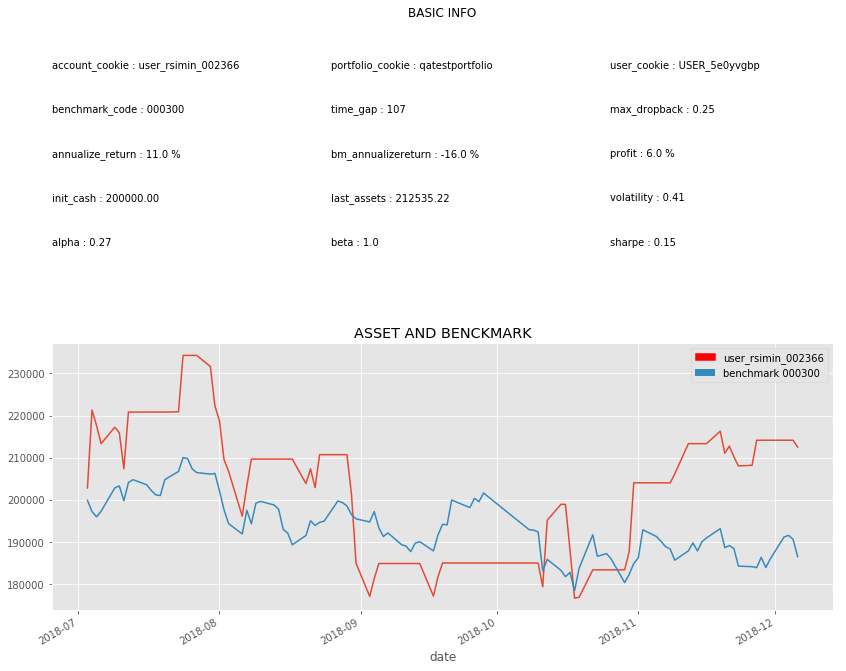

In [97]:
r_rsi.plot_assets_curve().show()

可以考虑试一下当rsi小于30且MA3上穿MA60的时候买入

rsi大于70或者MA3下穿MA60的时候卖出

但我们实际观察可以知道很多行情好的时候，rsi往往会远超过70

实际情况往往rsi的解释力不足, 可以配合成交量来判断?

ATR的止损是否能有效呢

看一下源代码吧,看看怎么做ATR的止损